# Grass growth model evaluation

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import geopandas as gpd

In [59]:
# read time series of grass growth
grass_pbi = pd.read_csv(
    os.path.join(
        "data", "grass_growth", "PastureBaseIreland", "pasturebase_cleaned.csv"
    )
)
grass_gcni = pd.read_csv(
    os.path.join(
        "data", "grass_growth", "GrassCheckNI", "grasscheck_cleaned.csv"
    )
)
mera = pd.read_csv(
    os.path.join("data", "ModVege", "growth", "MERA_growth_week_pasture.csv")
)

In [60]:
mera = mera.set_index("time")
mera.index = pd.to_datetime(mera.index)
mera.rename(columns={"COUNTY": "county", "mean": "value"}, inplace=True)
mera["county"] = mera["county"].str.title()
mera = mera["2013":"2018"]
mera["weekno"] = mera.index.isocalendar().week

In [61]:
mera

,county,value,weekno
time,,,
2013-01-07,Donegal,0.510065,2
2013-01-07,Limerick,0.881910,2
2013-01-07,Kildare,0.800824,2
2013-01-07,Waterford,0.869449,2
2013-01-07,Dublin,1.276233,2
...,...,...,...
2018-12-31,Antrim,0.779210,1
2018-12-31,Armagh,0.861603,1
2018-12-31,Fermanagh,1.025990,1


In [62]:
grass = pd.concat([grass_pbi, grass_gcni])
grass = pd.pivot_table(
    grass[["time", "county", "value"]],
    values="value",
    index=["time"],
    columns=["county"],
)
grass.index = pd.to_datetime(grass.index)
grass = grass["2013":"2018"]
grass = grass.melt(ignore_index=False)
grass["weekno"] = grass.index.isocalendar().week

In [63]:
grass

,county,value,weekno
time,,,
2013-01-07,Antrim,NaN,2
2013-01-14,Antrim,NaN,3
2013-01-21,Antrim,NaN,4
2013-01-28,Antrim,NaN,5
2013-02-04,Antrim,NaN,6
...,...,...,...
2018-12-03,Wicklow,NaN,49
2018-12-10,Wicklow,NaN,50
2018-12-17,Wicklow,NaN,51


In [64]:
# label measured and simulated data and merge
grass["data"] = "Measured"
mera["data"] = "Simulated"
data_all = pd.concat([grass, mera])

In [77]:
data_all["doy"] = data_all.index.dayofyear
data_all["year"] = data_all.index.year

In [78]:
data_all

,county,value,weekno,data,doy,year
time,,,,,,
2013-01-07,Antrim,NaN,2,Measured,7,2013
2013-01-14,Antrim,NaN,3,Measured,14,2013
2013-01-21,Antrim,NaN,4,Measured,21,2013
2013-01-28,Antrim,NaN,5,Measured,28,2013
2013-02-04,Antrim,NaN,6,Measured,35,2013
...,...,...,...,...,...,...
2018-12-31,Antrim,0.779210,1,Simulated,365,2018
2018-12-31,Armagh,0.861603,1,Simulated,365,2018
2018-12-31,Fermanagh,1.025990,1,Simulated,365,2018


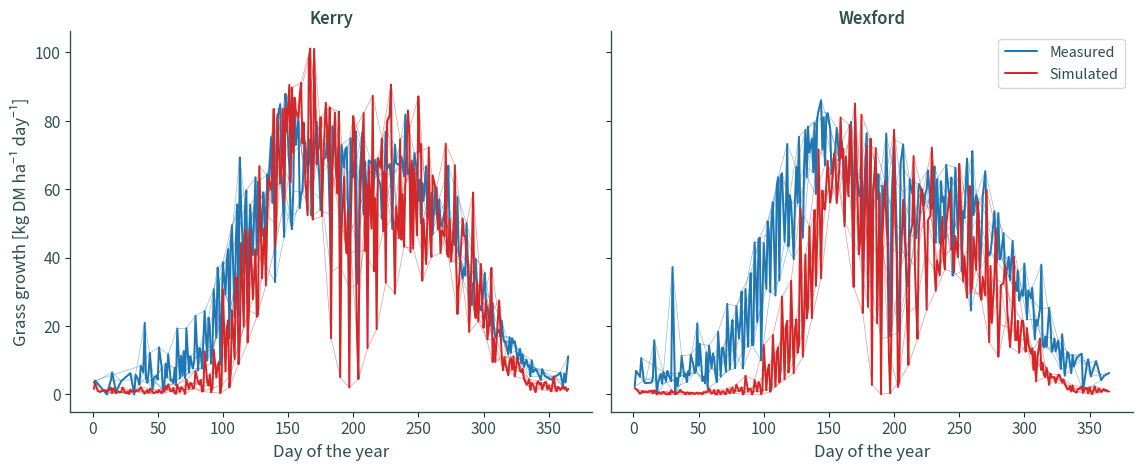

In [108]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
for n, (c, l) in enumerate(zip(["Kerry", "Wexford"], [False, True])):
    for year in list(set(data_all["year"])):
        sns.lineplot(data=data_all[(data_all["county"] == c) & (data_all["year"] == year)].reset_index(), x="doy", y="value", hue="data", errorbar=("pi", 100), ax=ax[n], legend=False, palette=sns.color_palette(["tab:blue", "tab:red"]), lw=0.5, alpha=.5)
    sns.lineplot(data=data_all[data_all["county"] == c].drop(columns=["county"]).groupby(["doy", "data"]).mean().sort_values(by=["doy"]), x="doy", y="value", hue="data", errorbar=("pi", 100), ax=ax[n], legend=l, palette=sns.color_palette(["tab:blue", "tab:red"]))
    ax[n].set_title(c)
    ax[n].set_xlabel("Day of the year")
    ax[n].set_ylabel("Grass growth [kg DM ha⁻¹ day⁻¹]")
plt.legend(title=None, fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

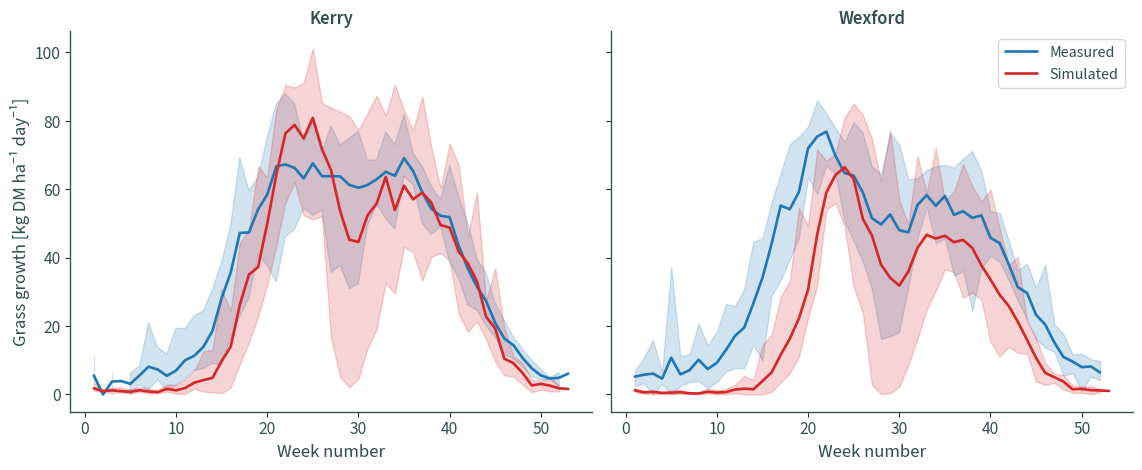

In [30]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
for n, (c, l) in enumerate(zip(["Kerry", "Wexford"], [False, True])):
    sns.lineplot(data=data_all[data_all["county"] == c].reset_index(), x="weekno", y="value", hue="data", errorbar=("pi", 100), ax=ax[n], legend=l, palette=sns.color_palette(["tab:blue", "tab:red"]), lw=2)
    ax[n].set_title(c)
    ax[n].set_xlabel("Week number")
    ax[n].set_ylabel("Grass growth [kg DM ha⁻¹ day⁻¹]")
plt.legend(title=None, fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

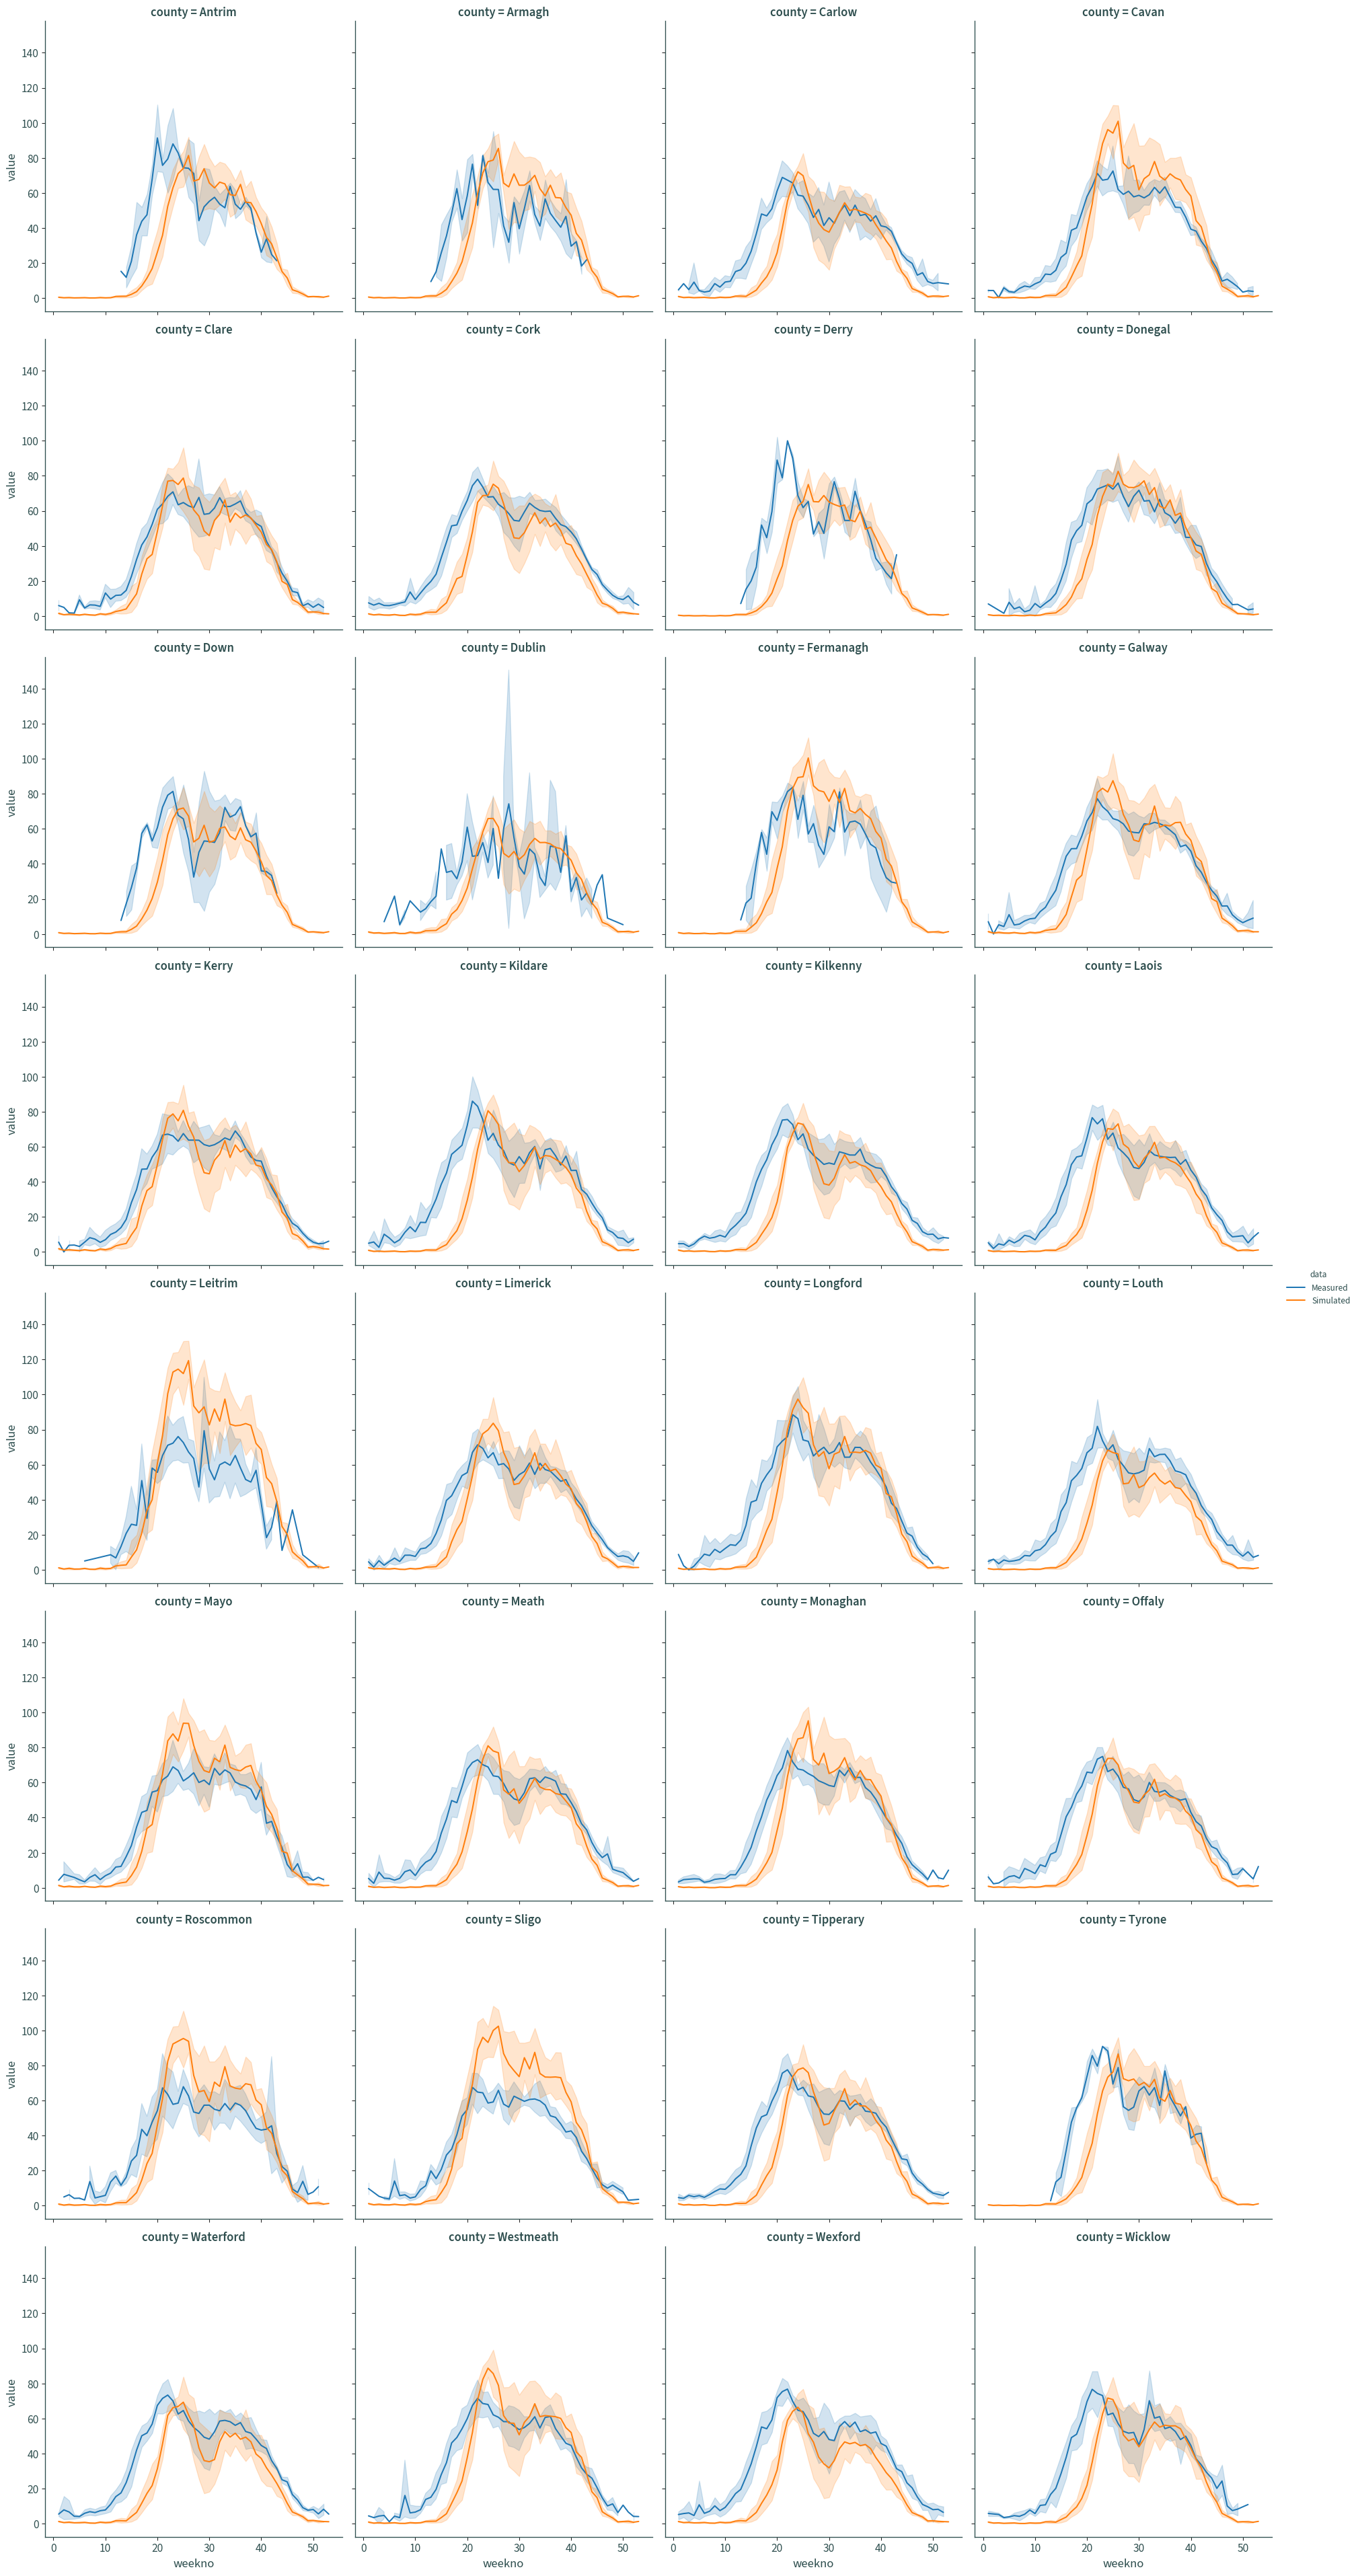

In [102]:
sns.relplot(data=data_all.reset_index(), x="weekno", y="value", hue="data", col="county", col_wrap=4, kind="line")
plt.show()